In [1]:
%pip install numpy matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\mauricio\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from collections import deque
from math import ceil

In [3]:
# Parâmetros (configuráveis)

DURACAO_SIMULACAO_MIN = 30
DURACAO_SIMULACAO_SEC = DURACAO_SIMULACAO_MIN * 60
CICLO_PADRAO = 60
LARGURA_TRAVESSIA = 10
VEL_PED = 0.97
TEMPO_TRAVESSIA = int(np.ceil(LARGURA_TRAVESSIA / VEL_PED))
G_MIN = TEMPO_TRAVESSIA + 5
G_MAX = 90
YELLOW_TIME = 3
SENSOR_RUIDO_PCT = 0.15
GAP_THRESHOLD = 5
MEDIA_CARROS_A = 12
MEDIA_CARROS_B = 10
PROB_PEDESTRE = 0.3
PROB_PRIORIDADE = 0.05
TAXA_ESCOAMENTO = 0.6
SIM_DT = 1
SAMPLE_RATE = 1
MAX_SNAPSHOTS = 2000
SEED = 42

# Se quiser resultados variados, comente as linhas abaixo
# random.seed(SEED)
# np.random.seed(SEED)


print(f"Simulação configurada para {DURACAO_SIMULACAO_MIN} minutos.")
print(f"Tempo mínimo de verde para a segurança do pedestre: {G_MIN} segundos.")

Simulação configurada para 30 minutos.
Tempo mínimo de verde para a segurança do pedestre: 16 segundos.


In [4]:
# Simula falha técnica/imprecisão dos sensores reais
def ruido_sensor(valor_real, erro_max=SENSOR_RUIDO_PCT):
    # Adiciona ruído percentual ao valor real.
    if valor_real <= 0: return 0
    
    fator = 1 + random.uniform(-erro_max, erro_max)
    valor_ruidoso = int(valor_real * fator)
    return max(0, valor_ruidoso)

# Usa Distribuição de Poisson para simular chegada aleatória, mas realista, de carros
def gerar_fluxo_carros(taxa_media_minuto, tempo_decorrido_sec):
    # Usa Poisson: A probabilidade de X carros chegarem num intervalo de tempo.
    lambda_poisson = (taxa_media_minuto / 60) * tempo_decorrido_sec
    chegadas = np.random.poisson(lambda_poisson)
    return chegadas

def detectar_prioridade(probabilidade):
    # Retorna True se houver Ambulância, Bombeiro ou Ônibus detectado.
    return random.random() < probabilidade

def detectar_pedestre(probabilidade):
    # Retorna True se botão de pedestre foi acionado ou detecção visual.
    return random.random() < probabilidade

In [5]:
class Vehicle:
    def __init__(self, id, is_bus=False):
        self.id = id
        self.is_bus = is_bus
        self.pos = -random.uniform(5, 25) # Carro nasce em posição aleatória antes da faixa
        self.wait_time = 0.0

class Lane:
    def __init__(self, name):
        self.name = name
        self.vehicles = deque() # Fila de carros (FIFO)
        self.passed = 0 # Contador de carros que cruzaram

    # Adiciona novos carros à fila
    def add_vehicles(self, n, start_id, bus_prob=0.0):
        for i in range(n):
            is_bus = random.random() < bus_prob
            v = Vehicle(start_id + i, is_bus=is_bus)
            self.vehicles.append(v)
        return n

    def queue_length(self):
        return len(self.vehicles)


    # Lógica física de movimento dos carros
    def step_logic(self, is_green, dt, discharge_rate):
        passed_now = 0
        waited_sum = 0.0
        
        # Se sinal verde: Calcula quantos carros conseguem sair (Taxa de Escoamento)
        if is_green:
            expected = discharge_rate * dt
            
            # Parte inteira + chance probabilística da fração 
            base = int(np.floor(expected))
            extra = 1 if random.random() < (expected - base) else 0
            capacity = base + extra

            # Remove carros que passaram da linha (pos > -2)
            for _ in range(capacity):
                if not self.vehicles: break
                if self.vehicles[0].pos > -2: 
                    v = self.vehicles.popleft()
                    waited_sum += v.wait_time
                    self.passed += 1
                    passed_now += 1
        
        # Atualiza posição dos carros restantes
        for i, veh in enumerate(self.vehicles):

            # Calcula distância para o carro da frente (para não bater)
            dist_to_next = 100
            if i > 0:
                dist_to_next = self.vehicles[i-1].pos - veh.pos - 2

            # Se verde: acelera. Se vermelho: freia até a linha 0.
            if is_green:
                move = min(1.5 * dt, 5.0)
            else:
                target = 0 if i == 0 else (self.vehicles[i-1].pos - 2)
                dist = target - veh.pos
                move = max(0, min(dist, 1.5 * dt))
            
            # Limita movimento para não atravessar carro da frente
            if i > 0 and move > dist_to_next:
                move = max(0, dist_to_next)
                
            veh.pos += move
            
            # Se carro andou muito pouco, conta como tempo de espera
            if move < 0.1:
                veh.wait_time += dt

        return passed_now, waited_sum

class ActuatedController:
    def __init__(self, laneA, laneB):
        self.laneA = laneA
        self.laneB = laneB
        self.phase = 'A'
        self.phase_time = 0
        self.green_limit = G_MAX # Limite dinâmico de verde
        self.green_times_log = [] 

    # Lê sensores considerando o ruído definido nas config
    def sense(self):
        return ruido_sensor(self.laneA.queue_length()), ruido_sensor(self.laneB.queue_length())

    # HEURÍSTICA: Decide se mantem (hold) ou troca (switch) o sinal
    def decide(self, ped_A, ped_B, v2i_A, v2i_B):
        detA, detB = self.sense()
        
        # Se está no Amarelo, apenas aguarda o tempo de segurança
        if 'YELLOW' in self.phase:
            if self.phase_time >= YELLOW_TIME: return 'next_green'
            return 'hold'

        # Identifica quem tem o verde agora e quem está esperando
        current_lane_q = detA if self.phase == 'A' else detB
        other_lane_q = detB if self.phase == 'A' else detA
        has_priority = v2i_A if self.phase == 'A' else v2i_B # Ambulância na minha via
        other_priority = v2i_B if self.phase == 'A' else v2i_A  # Ambulância na via fechada
        
        # Regra de Prioridade (V2I)
        # Se a via fechada tem prioridade, tenta trocar assim que der o tempo mínimo
        if other_priority and not has_priority:
            if self.phase_time >= G_MIN: return 'switch'
        # Se eu tenho prioridade, seguro o verde até o máximo possível
        if has_priority:
            if self.phase_time < G_MAX: return 'hold'

        # Regra Gap-Out (Otimização de Fluxo)
        # Se via atual esvaziou (<= 1 carro) e já cumpriu tempo mínimo, passa a vez
        if current_lane_q <= 1 and self.phase_time >= G_MIN:
            if other_lane_q > 0: return 'switch' # Só troca se tiver alguém esperando
        
        # Regra Max-Out (Limite Fixo)
        # Se estourou o tempo máximo permitido, força a troca
        if self.phase_time >= self.green_limit: return 'switch'

        return 'hold'

    def step(self, dt, ped_A, ped_B, v2i_A, v2i_B):
        action = self.decide(ped_A, ped_B, v2i_A, v2i_B)
        
        if action == 'hold':
            self.phase_time += dt
            
        elif action == 'switch':
          
            # Salva dados para o gráfico e inicia amarelo
            self.green_times_log.append((self.phase, self.phase_time))
            self.phase = f"YELLOW_{self.phase}"
            self.phase_time = 0
            
        elif action == 'next_green':
            # Troca efetiva de fase (A -> B ou B -> A)
            if self.phase == 'YELLOW_A':
                self.phase = 'B'
            else:
                self.phase = 'A'
            self.phase_time = 0
            
            # Split: Recalcula o tempo máximo do próximo verde
            # Baseado na proporção das filas (quem tem mais fila ganha mais tempo limite)
            qA = max(1, self.laneA.queue_length())
            qB = max(1, self.laneB.queue_length())
            ratio = qA / (qA + qB) if self.phase == 'A' else qB / (qA + qB)
            self.green_limit = int(np.clip(CICLO_PADRAO * ratio, G_MIN, G_MAX))

        return self.phase


 RESULTADOS FINAIS DA HEURÍSTICA
Total de veículos atendidos: 677
Tempo médio de espera:       12.13 segundos
Eventos de prioridade (V2I): 171


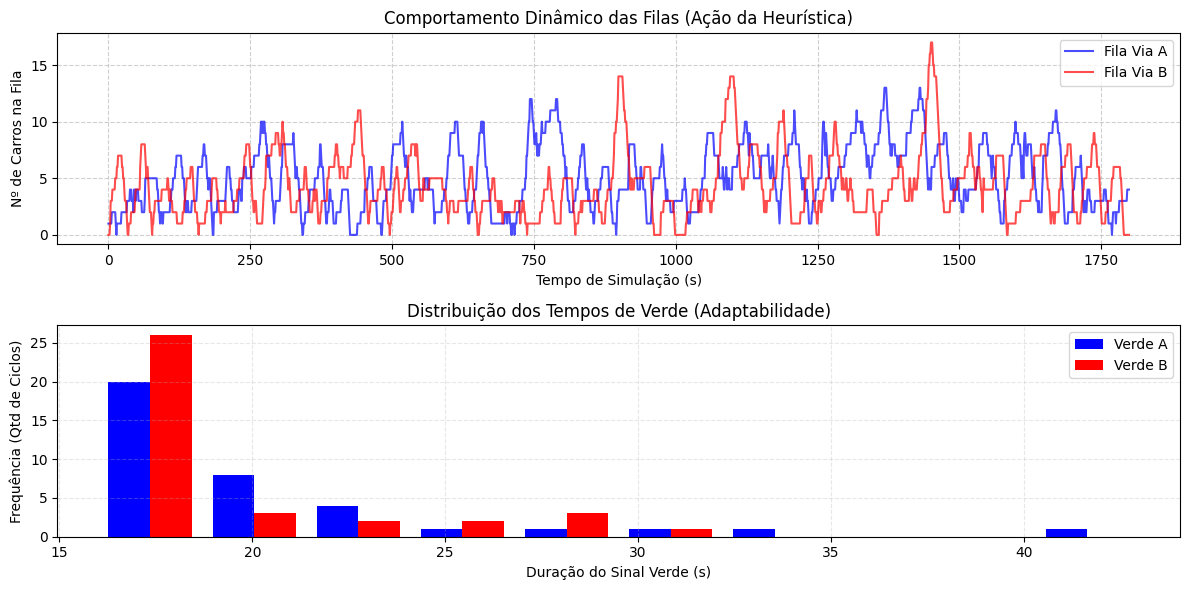

In [6]:
def run_simulation():
    laneA = Lane('A')
    laneB = Lane('B')
    controller = ActuatedController(laneA, laneB)

    t = 0
    vehicle_id = 0
    snapshots = []
    
    total_passed = 0
    total_wait_passed = 0.0
    priority_events = 0

    while t < DURACAO_SIMULACAO_SEC:
        chegA = gerar_fluxo_carros(MEDIA_CARROS_A, SIM_DT)
        chegB = gerar_fluxo_carros(MEDIA_CARROS_B, SIM_DT)
        laneA.add_vehicles(chegA, vehicle_id, bus_prob=PROB_PRIORIDADE)
        vehicle_id += chegA
        laneB.add_vehicles(chegB, vehicle_id, bus_prob=PROB_PRIORIDADE)
        vehicle_id += chegB

        ped_A = detectar_pedestre(PROB_PEDESTRE * SIM_DT)
        ped_B = detectar_pedestre(PROB_PEDESTRE * SIM_DT)
        v2i_A = detectar_prioridade(PROB_PRIORIDADE * SIM_DT)
        v2i_B = detectar_prioridade(PROB_PRIORIDADE * SIM_DT)
        if v2i_A or v2i_B: priority_events += 1

        current_phase = controller.step(SIM_DT, ped_A, ped_B, v2i_A, v2i_B)

        green_A = (current_phase == 'A')
        green_B = (current_phase == 'B')
        
        pA, wA = laneA.step_logic(green_A, SIM_DT, TAXA_ESCOAMENTO)
        pB, wB = laneB.step_logic(green_B, SIM_DT, TAXA_ESCOAMENTO)
        
        total_passed += (pA + pB)
        total_wait_passed += (wA + wB)

        if t % SAMPLE_RATE == 0:
            snapshots.append({
                't': t,
                'qA': laneA.queue_length(),
                'qB': laneB.queue_length(),
                'phase': current_phase
            })
        t += SIM_DT

    return {
        'total_passed': total_passed,
        'avg_wait': total_wait_passed / max(1, total_passed),
        'priority_events': priority_events,
        'snapshots': snapshots,
        'green_log': controller.green_times_log
    }

metrics = run_simulation()

print("\n" + "="*40)
print(" RESULTADOS FINAIS DA HEURÍSTICA")
print("="*40)
print(f"Total de veículos atendidos: {metrics['total_passed']}")
print(f"Tempo médio de espera:       {metrics['avg_wait']:.2f} segundos")
print(f"Eventos de prioridade (V2I): {metrics['priority_events']}")
print("="*40)

snaps = metrics['snapshots']
times = [s['t'] for s in snaps]
qA = [s['qA'] for s in snaps]
qB = [s['qB'] for s in snaps]

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(times, qA, label='Fila Via A', color='blue', alpha=0.7)
plt.plot(times, qB, label='Fila Via B', color='red', alpha=0.7)
plt.title("Comportamento Dinâmico das Filas (Ação da Heurística)")
plt.ylabel("Nº de Carros na Fila")
plt.xlabel("Tempo de Simulação (s)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.subplot(2, 1, 2)
verdes_A = [t for p, t in metrics['green_log'] if p == 'A']
verdes_B = [t for p, t in metrics['green_log'] if p == 'B']
plt.hist([verdes_A, verdes_B], label=['Verde A', 'Verde B'], color=['blue', 'red'], bins=10)
plt.title("Distribuição dos Tempos de Verde (Adaptabilidade)")
plt.xlabel("Duração do Sinal Verde (s)")
plt.ylabel("Frequência (Qtd de Ciclos)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()